# 数据获取

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [118]:
import tushare as ts
token='填写你的token'
pro=ts.pro_api(token)

In [119]:
#获取交易日历
def get_cal_date(start,end):
    cal_date=pro.trade_cal(exchange='', start_date=start, end_date=end)
    cal_date=cal_date[cal_date.is_open==1]
    dates=cal_date.cal_date.values
    return dates

In [120]:
#获取北向资金数据
def get_north_money(start,end):
    #获取交易日历
    dates=get_cal_date(start,end)
    #tushare限制流量，每次只能获取300条记录
    df=pro.moneyflow_hsgt(start_date=start, end_date=end)
    #拆分时间进行拼接，再删除重复项
    for i in range(0,len(dates)-300,300):
        d0=pro.moneyflow_hsgt(start_date=dates[i], end_date=dates[i+300])
        df=pd.concat([d0,df])
        #删除重复项
        df=df.drop_duplicates()
        df.index=pd.to_datetime(df.trade_date)
        df=df.sort_index()
    return df

In [121]:
#获取指数数据
def get_index_data(code,start,end):
    index_df = pro.index_daily(ts_code=code, start_date=start,end_date=end)
    index_df.index=pd.to_datetime(index_df.trade_date)
    index_df=index_df.sort_index()
    return index_df

In [122]:
#获取指数数据
#常用大盘指数
indexs={'上证综指': '000001.SH','深证成指': '399001.SZ','沪深300': '000300.SH',
       '创业板指': '399006.SZ','上证50': '000016.SH','中证500': '000905.SH',
       '中小板指': '399005.SZ','上证180': '000010.SH'}
start='20141117'
end='20200812'

In [123]:
index_data=pd.DataFrame()
for name,code in indexs.items():
    index_data[name]=get_index_data(code,start,end)['close']
index_data.tail()

,上证综指,深证成指,沪深300,创业板指,上证50,中证500,中小板指,上证180
trade_date,,,,,,,,
2020-08-06,3386.4631,13863.1298,4762.7642,2814.3737,3292.2003,6770.3016,9222.7909,9798.7426
2020-08-07,3354.0352,13648.4996,4707.9262,2749.9533,3263.7455,6688.8822,9095.9286,9707.9816
2020-08-10,3379.2524,13657.3134,4724.8697,2735.2561,3285.7602,6725.2956,9079.2589,9760.5009
2020-08-11,3340.2900,13466.2675,4681.7837,2688.7004,3262.8244,6600.8472,8974.4587,9671.6450
2020-08-12,3319.2656,13308.5217,4647.6446,2635.5022,3249.7381,6528.3999,8916.4511,9614.0586


In [8]:
#index_data.to_csv('index_data.csv')

In [9]:
#从本地读取数据
#index_data=pd.read_csv('index_data.csv',index_col=0,header=0)

# 探索性分析

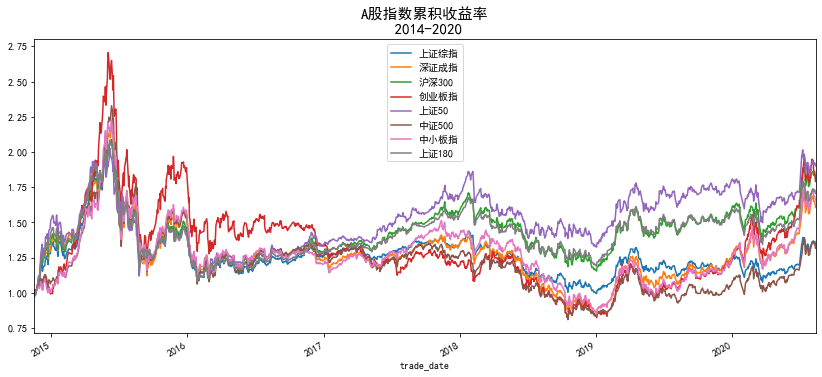

In [124]:
#累计收益
(index_data/index_data.iloc[0]).plot(figsize=(14,6))
plt.title('A股指数累积收益率\n 2014-2020',size=15)
plt.show()

In [125]:
#将价格数据转为收益率
all_ret=index_data/index_data.shift(1)-1
all_ret.tail()

,上证综指,深证成指,沪深300,创业板指,上证50,中证500,中小板指,上证180
trade_date,,,,,,,,
2020-08-06,0.002635,-0.007005,-0.003003,-0.016036,-0.000033,-0.000375,-0.005655,0.002676
2020-08-07,-0.009576,-0.015482,-0.011514,-0.022890,-0.008643,-0.012026,-0.013755,-0.009263
2020-08-10,0.007518,0.000646,0.003599,-0.005345,0.006745,0.005444,-0.001833,0.005410
2020-08-11,-0.011530,-0.013989,-0.009119,-0.017021,-0.006980,-0.018505,-0.011543,-0.009104
2020-08-12,-0.006294,-0.011714,-0.007292,-0.019786,-0.004011,-0.010975,-0.006464,-0.005954


In [126]:
north_data=get_north_money(start,end)
#north_data.to_csv('north_data.csv')
#north_data=pd.read_csv('north_data',index_col=0,header=0)
all_data=all_ret.join(north_data['north_money'],how='inner')
all_data.rename(columns={'north_money':'北向资金'},inplace=True)
all_data.dropna(inplace=True)

In [13]:
all_data.corr()

,上证综指,深证成指,沪深300,创业板指,上证50,中证500,中小板指,上证180,北向资金
上证综指,1.000000,0.924464,0.979941,0.765474,0.907355,0.890101,0.865520,0.970900,0.252699
深证成指,0.924464,1.000000,0.916748,0.901830,0.753318,0.962117,0.961679,0.860130,0.290307
沪深300,0.979941,0.916748,1.000000,0.740999,0.942523,0.849081,0.858023,0.989113,0.291449
创业板指,0.765474,0.901830,0.740999,1.000000,0.534840,0.923303,0.937949,0.667121,0.263519
上证50,0.907355,0.753318,0.942523,0.534840,1.000000,0.652926,0.668452,0.974577,0.270995
中证500,0.890101,0.962117,0.849081,0.923303,0.652926,1.000000,0.962797,0.789607,0.235865
中小板指,0.865520,0.961679,0.858023,0.937949,0.668452,0.962797,1.000000,0.789089,0.293066
上证180,0.970900,0.860130,0.989113,0.667121,0.974577,0.789607,0.789089,1.000000,0.272773
北向资金,0.252699,0.290307,0.291449,0.263519,0.270995,0.235865,0.293066,0.272773,1.000000


In [14]:
all_data.rolling(120).corr().tail(9)

上证综指      深证成指     沪深300      创业板指      上证50     中证500  \
trade_date                                                                     
2020-08-12 上证综指   1.000000  0.929499  0.987080  0.832694  0.964184  0.921310   
           深证成指   0.929499  1.000000  0.945616  0.964512  0.843982  0.980542   
           沪深300  0.987080  0.945616  1.000000  0.854003  0.969139  0.911526   
           创业板指   0.832694  0.964512  0.854003  1.000000  0.723766  0.949704   
           上证50   0.964184  0.843982  0.969139  0.723766  1.000000  0.808102   
           中证500  0.921310  0.980542  0.911526  0.949704  0.808102  1.000000   
           中小板指   0.893568  0.987329  0.916322  0.958564  0.803494  0.965511   
           上证180  0.987040  0.891497  0.987366  0.782050  0.991134  0.866490   
           北向资金   0.666148  0.635636  0.700535  0.580554  0.702172  0.576626   

                      中小板指     上证180      北向资金  
trade_date                                      
2020-08-12 上证综指   0.893568  0.987040  0.666148  
           深证成指   0.987329  0.891497  0.635636  
           沪深300  0.916322  0.987366  0.700535  
           创业板指   0.958564  0.782050  0.580554  
           上证50   0.803494  0.991134  0.702172  
           中证500  0.965511  0.866490  0.576626  
           中小板指   1.000000  0.855046  0.628698  
           上证180  0.855046  1.000000  0.690962  
           北向资金   0.628698  0.690962  1.000000

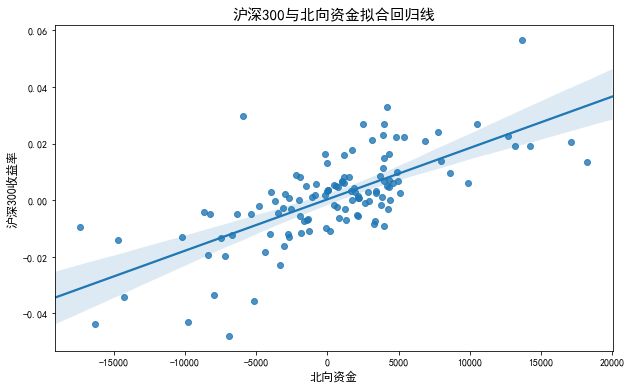

In [23]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.regplot(x=list(all_data["北向资金"][-120:]),y=list(all_data["沪深300"][-120:]))
plt.title('沪深300与北向资金拟合回归线',size=15)
plt.xlabel('北向资金',size=12)
plt.ylabel('沪深300收益率',size=12)
plt.show()

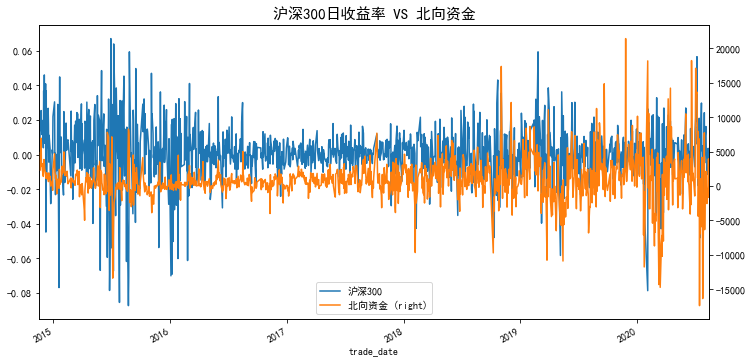

In [28]:
#沪深300指数收益率与北向资金
final_data=all_data[['沪深300','北向资金']].dropna()
final_data.plot(secondary_y='北向资金',figsize=(12,6))
plt.title('沪深300日收益率 VS 北向资金',size=15)
plt.show()

In [29]:
#获取北向资金与沪深300收益率的滚动窗口相关系数
def cal_rol_cor(data,period=30):
    cors=data.rolling(period).corr()
    cors=cors.dropna().iloc[1::2,0]
    cors=cors.reset_index()
    cors=cors.set_index('trade_date')
    return cors['沪深300']

In [44]:
cor=cal_rol_cor(final_data,period=120)
cor.describe()

count    1236.000000
mean        0.334559
std         0.219806
min        -0.215172
25%         0.219457
50%         0.379527
75%         0.525442
max         0.705992
Name: 沪深300, dtype: float64

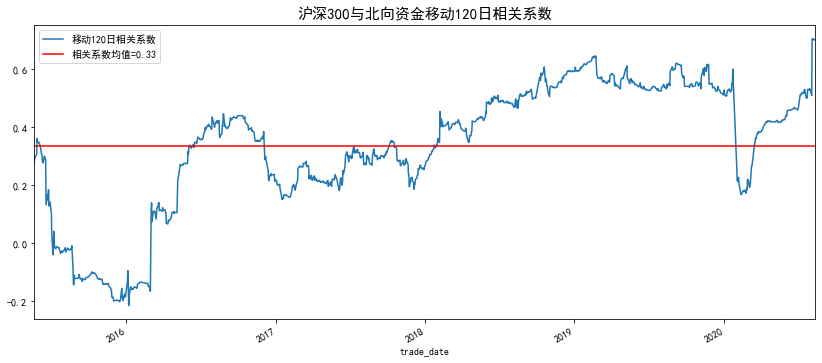

In [58]:
cor.plot(figsize=(14,6),label='移动120日相关系数')
plt.title('沪深300与北向资金移动120日相关系数',size=15)
plt.axhline(cor.mean(), c='r',label='相关系数均值=0.33')
plt.legend(loc=2)
plt.show()

# 策略实例

基于北向资金变动数据构建布林带择时策略能有效判断市场短期涨跌

至于北向资金是否具有指示作用，我们可以通过择时模型的回测表现来进行观测。为此， 我们基于北向资金的流入规模数据构建布林带策略：

（1） 当该日北向资金流入规模 > 过去 252 个交易日的北向资金均值 + 1.5 倍标准差， 则全仓买入沪深 300；

（2） 当该日北向资金流入规模 < 过去 252 个交易日的北向资金均值 - 1.5 倍标准差， 则清仓卖出沪深 300；

（3） 以第二天开盘价买入计量。

In [102]:
def North_Strategy(data,window,stdev_n,cost):
    '''输入参数：
    data:包含北向资金和指数价格数据
    window:移动窗口
    stdev_n:几倍标准差
    cost:手续费
    '''
    # 中轨
    df=data.copy().dropna()
    df['mid'] = df['北向资金'].rolling(window).mean()
    stdev = df['北向资金'].rolling(window).std()
    # 上下轨
    df['upper'] = df['mid'] + stdev_n * stdev
    df['lower'] = df['mid'] - stdev_n * stdev
    df['ret']=df.close/df.close.shift(1)-1
    df.dropna(inplace=True)
   
    #设计买卖信号
    #当日北向资金突破上轨线发出买入信号设置为1
    df.loc[df['北向资金']>df.upper, 'signal'] = 1
    #当日北向资金跌破下轨线发出卖出信号设置为0
    df.loc[df['北向资金']<df.lower, 'signal'] = 0
    df['position']=df['signal'].shift(1)
    df['position'].fillna(method='ffill',inplace=True)
    df['position'].fillna(0,inplace=True)
    #根据交易信号和仓位计算策略的每日收益率
    df.loc[df.index[0], 'capital_ret'] = 0
    #今天开盘新买入的position在今天的涨幅(扣除手续费)
    df.loc[df['position'] > df['position'].shift(1), 'capital_ret'] = \
                         (df.close/ df.open-1) * (1- cost) 
    #卖出同理
    df.loc[df['position'] < df['position'].shift(1), 'capital_ret'] = \
                   (df.open / df.close.shift(1)-1) * (1-cost) 
    # 当仓位不变时,当天的capital是当天的change * position
    df.loc[df['position'] == df['position'].shift(1), 'capital_ret'] = \
                        df['ret'] * df['position']
    #计算标的、策略、指数的累计收益率
    df['策略净值']=(df.capital_ret+1.0).cumprod()
    df['指数净值']=(df.ret+1.0).cumprod()
    return df

策略评价指标

In [103]:
def performance(df):
    df1 = df.loc[:,['ret','capital_ret']]
    # 计算每一年(月,周)股票,资金曲线的收益
    year_ret = df1.resample('A').apply(lambda x: (x + 1.0).prod() - 1.0)
    month_ret = df1.resample('M').apply(lambda x: (x + 1.0).prod() - 1.0)
    week_ret = df1.resample('W').apply(lambda x: (x + 1.0).prod() - 1.0)
    #去掉缺失值
    year_ret.dropna(inplace=True)
    month_ret.dropna(inplace=True)
    week_ret.dropna(inplace=True)
    # 计算策略的年（月，周）胜率
    year_win_rate = len(year_ret[year_ret['capital_ret'] > 0]) / len(year_ret[year_ret['capital_ret'] != 0])
    month_win_rate = len(month_ret[month_ret['capital_ret'] > 0]) / len(month_ret[month_ret['capital_ret'] != 0])
    week_win_rate = len(week_ret[week_ret['capital_ret'] > 0]) / len(week_ret[week_ret['capital_ret'] != 0])
    #计算总收益率、年化收益率和风险指标
    total_ret=df[['策略净值','指数净值']].iloc[-1]-1
    annual_ret=pow(1+total_ret,250/len(df1))-1
    dd=(df[['策略净值','指数净值']].cummax()-\
        df[['策略净值','指数净值']])/\
        df[['策略净值','指数净值']].cummax()
    d=dd.max()
    beta=df[['capital_ret','ret']].cov().iat[0,1]/df['ret'].var()
    alpha=(annual_ret['策略净值']-annual_ret['指数净值']*beta)
    exReturn=df['capital_ret']-0.03/250
    sharper_atio=np.sqrt(len(exReturn))*exReturn.mean()/exReturn.std()
    TA1=round(total_ret['策略净值']*100,2)
    TA2=round(total_ret['指数净值']*100,2)
    AR1=round(annual_ret['策略净值']*100,2)
    AR2=round(annual_ret['指数净值']*100,2)
    MD1=round(d['策略净值']*100,2)
    MD2=round(d['指数净值']*100,2)
    S=round(sharper_atio,2)
    #输出结果
    print (f'策略年胜率为：{round(year_win_rate*100,2)}%' )
    print (f'策略月胜率为：{round(month_win_rate*100,2)}%' )
    print (f'策略周胜率为：{round(week_win_rate*100,2)}%' )
   
    print(f'总收益率：  策略：{TA1}%，沪深300：{TA2}%')
    print(f'年化收益率：策略：{AR1}%, 沪深300：{AR2}%')
    print(f'最大回撤：  策略：{MD1}%, 沪深300：{MD2}%')
    print(f'策略Alpha： {round(alpha,2)}, Beta：{round(beta,2)}，夏普比率：{S}')

In [110]:
#对策略累计收益率进行可视化
def plot_performance(df,name):
    d1=df[['策略净值','指数净值','signal']]
    d1[['策略净值','指数净值']].plot(figsize=(15,7))
    
    for i in d1.index:
        v=d1['指数净值'][i]
        if d1.signal[i]==1:
            plt.scatter(i, v, c='r')
        if d1.signal[i]==0:
            plt.scatter(i, v, c='g')
    
    plt.title(name+'—'+'北向资金择时交易策略回测',size=15)
    plt.xlabel('')
    ax=plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.show()

In [111]:
#将上述函数整合成一个执行函数
def main(code='000300.SH',start='20141117',end='20200812',window=252,stdev_n=1.5,cost=0.00):
    hs300=get_index_data(code,start,end)
    north_data=get_north_money(start,end)
    result_df=hs300.join(north_data['north_money'],how='inner')
    result_df.rename(columns={'north_money':'北向资金'},inplace=True)
    result_df=result_df[['close','open','北向资金']].dropna()
    df=North_Strategy(result_df,window,stdev_n,cost)
    name=list (indexs.keys()) [list (indexs.values()).index (code)]
    print(f'回测标的：{name}指数')
    startDate=df.index[0].strftime('%Y%m%d')
    print(f'回测期间：{startDate}—{end}')
    performance(df)
    plot_performance(df,name)

回测标的：沪深300指数
回测期间：20151208—20200812
策略年胜率为：80.0%
策略月胜率为：64.58%
策略周胜率为：60.98%
总收益率：  策略：106.36%，沪深300：26.03%
年化收益率：策略：17.81%, 沪深300：5.37%
最大回撤：  策略：17.28%, 沪深300：32.46%
策略Alpha： 0.15, Beta：0.46，夏普比率：2.2


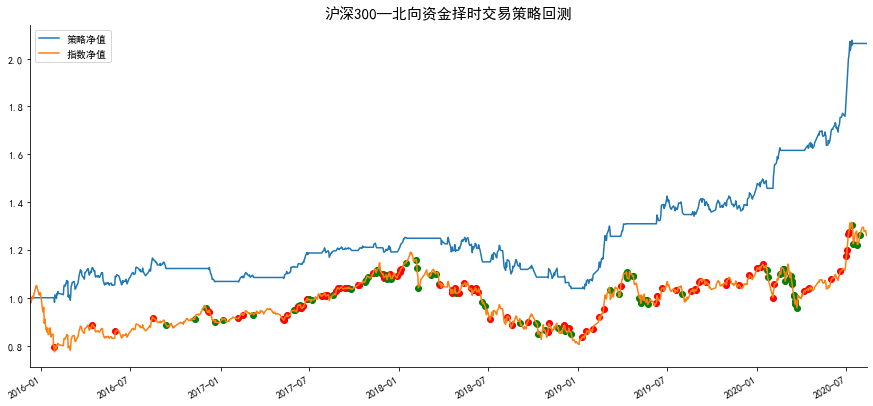

In [112]:
main(code='000300.SH')

回测标的：沪深300指数
回测期间：20171205—20200812
策略年胜率为：50.0%
策略月胜率为：65.52%
策略周胜率为：61.86%
总收益率：  策略：72.01%，沪深300：15.65%
年化收益率：策略：23.93%, 沪深300：5.92%
最大回撤：  策略：17.29%, 沪深300：32.46%
策略Alpha： 0.21, Beta：0.45，夏普比率：2.1


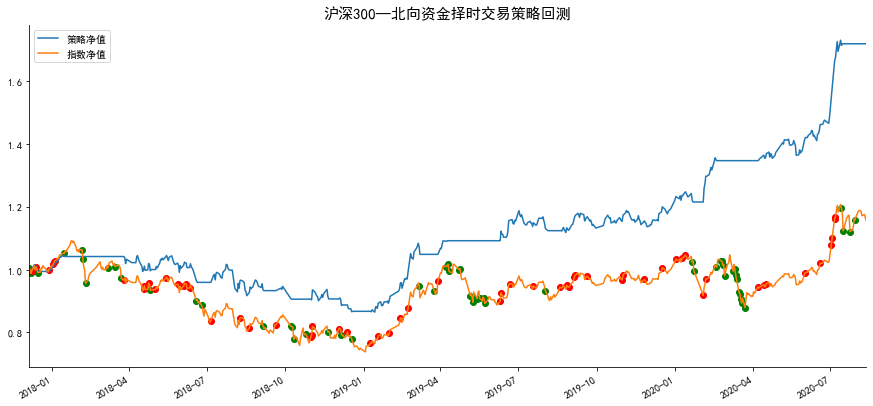

In [115]:
main(code='000300.SH',start='20161117',cost=0.01)

回测标的：创业板指指数
回测期间：20151208—20200812
策略年胜率为：80.0%
策略月胜率为：54.17%
策略周胜率为：54.88%
总收益率：  策略：133.88%，沪深300：-3.75%
年化收益率：策略：21.19%, 沪深300：-0.86%
最大回撤：  策略：37.17%, 沪深300：57.57%
策略Alpha： 0.22, Beta：0.5，夏普比率：1.92


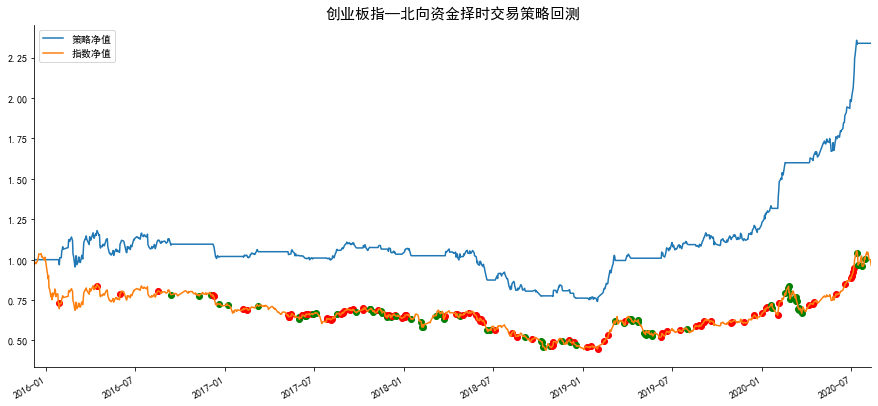

In [116]:
main(code='399006.SZ')

In [128]:
df

,close,open,北向资金,mid,upper,lower,ret,signal,position,capital_ret,策略净值,沪深300净值
trade_date,,,,,,,,,,,,
2015-12-08,3623.0202,3668.8385,-391.00,623.159206,4298.540275,-3052.221862,-0.017515,NaN,0.0,0.000000,1.000000,0.982485
2015-12-09,3635.9382,3613.4203,463.00,573.409206,4056.207205,-2909.388792,0.003566,NaN,0.0,0.000000,1.000000,0.985988
2015-12-10,3623.0842,3634.3660,-281.00,553.067937,4013.115196,-2906.979323,-0.003535,NaN,0.0,-0.000000,1.000000,0.982503
2015-12-11,3608.0587,3605.3723,-141.00,542.143333,3997.280802,-2912.994136,-0.004147,NaN,0.0,-0.000000,1.000000,0.978428
2015-12-14,3711.3220,3573.8838,-300.00,531.921111,3984.043323,-2920.201100,0.028620,NaN,0.0,0.000000,1.000000,1.006431
2015-12-15,3694.3885,3707.7304,411.00,524.262381,3972.132562,-2923.607800,-0.004563,NaN,0.0,-0.000000,1.000000,1.001839
2015-12-16,3685.4398,3703.9503,-474.00,494.778254,3889.473543,-2899.917035,-0.002422,NaN,0.0,-0.000000,1.000000,0.999412
2015-12-17,3755.8881,3712.7833,1297.00,488.603651,3876.787155,-2899.579854,0.019115,NaN,0.0,0.000000,1.000000,1.018516
2015-12-18,3767.9128,3754.9603,-54.00,475.313968,3853.394394,-2902.766457,0.003202,NaN,0.0,0.000000,1.000000,1.021777
